<h1><center>Detección de Fraude en transacciones de tarjetas de crédito</center></h1>

<p><center>Para este análisis se utilizó un dataset con 284,807 transacciones anónimas reales tomado de <a HREF="https://www.kaggle.com/dalpozz/creditcardfraud" TARGET="_BLANK">Kaggle</a>.</center><p>

In [20]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv('./Data/creditcard.csv')
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


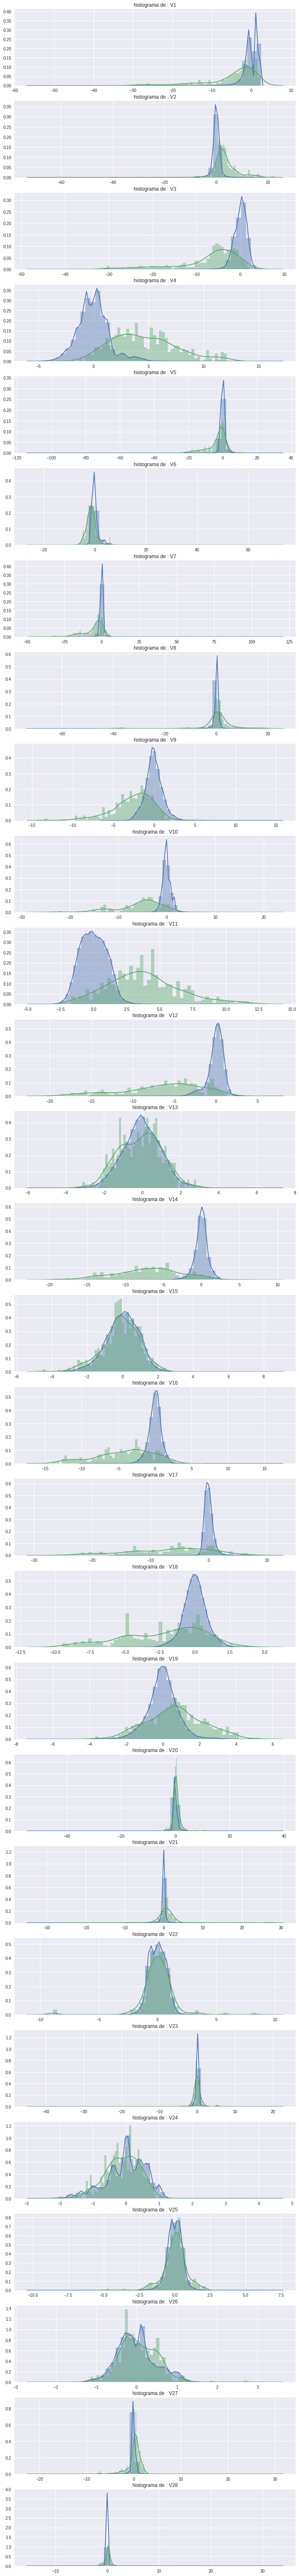

In [3]:
#Grafico de los histogramas por cada caracteristica
v_features = data.ix[:,1:29].columns

plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data.Class == 0], bins=50)
    sns.distplot(data[cn][data.Class == 1], bins=50)
    ax.set_xlabel('')
    ax.set_title('histograma de : ' + str(cn))
plt.show()

In [4]:
#Se eliminan las caracteristicas que no se diferencian mucho entre las dos clases
data = data.drop(['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V5','V6','V7','V8','Time','Amount'], axis =1)


In [5]:
#Solo se utilizan las transacciones normales para ajustas Mu y Sigma
normal = data[data.Class == 0]
fraud = data[data.Class == 1]
#Separacion de los dataset en test y pruebas
X_train = normal.sample(frac = 0.6)
X_CV = pd.concat([normal.sample(frac = 0.2),fraud.sample(frac = 0.50)], axis = 0)
X_test = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)
y_train, y_cv, y_test = X_train.pop('Class'), X_CV.pop('Class'), X_test.pop('Class')

m, n = X_train.shape
normal_y = normal.pop('Class')
fraud_y = fraud.pop('Class')

<h1><center>Distribución Gaussiana Multivariable</center></h1>
<h3><center>Sólo se utilizan los datos normales para calcular $\mu$ y $\Sigma$</center></h3>
<!--<h3><justify>Primero se ajustan los parametros $\mu$ y $\Sigma$ con los datos de las transacciones validas para encontrar las medias y la matriz de covarianza de las transacciones normales.</justify></h3>-->
<h2><center>$$\mu = \frac{1}{m} \sum_{i=0}^m x^i$$</center></h2>                  
<h2><center>$$\Sigma = \frac{1}{m} \sum_{i=0}^m (x^i - \mu)(x^i - \mu)^T$$</center></h2>
<h3><center>Luego para un nuevo ejemplo X, se calcula</center></h3>  
<h2>$$p(X) = \frac{1}{(2\pi)^\frac{n}{2}\left|\Sigma\right|^\frac{1}{2}}\exp{\left(-\frac{1}{2}(X - \mu)^T\Sigma^{-1}(X - \mu)\right)}$$</h2>
<h3><center>Si el valor de p(X) es menor a $\epsilon$ la transacción se marca como una anomalía</center></h3>


In [6]:
#Multivariable Gaussian Distribution
#Encuentra las medias por cada caracteristica de las transacciones
def mu(X):
    _mu = np.zeros((n, 1))
    for i in range(n):
        _mu[i] = (1 / m) * np.sum(X[:,i])
    return _mu

#Encuentra la matriz de covarianza de las caracteristicas de las transacciones
def sigma(X):
    _sigma = np.zeros((n, 1))
    _mu = mu(X)
    for i in range(n):
        _sigma[i] = (1 / m) * np.sum(np.dot(X[:, i] - _mu, (X[:, i] - _mu).T))
    
    return _sigma
    
#Funcion de densidad
def p(X, Mu, Sigma):
    k = Mu.shape[0]
    if Sigma.shape[0] == 1 or Sigma.shape[1] == 1:
        Sigma = np.diag(Sigma[:, 0])
    
    X = X - Mu.T
    r = (2 * np.pi) ** (-k / 2) * np.linalg.det(Sigma) ** (-0.5)
    e = np.exp(-0.5 * np.sum(np.dot(X , np.linalg.pinv(Sigma)) * X, 1))
    
    return r * e
    

In [7]:
#Busca el mejor valor de epsilon
def selectThreshold(predictions_CV, Y_CV):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (np.max(predictions_CV) - np.min(predictions_CV)) / 1000
    
    for epsilon in np.arange(min(predictions_CV), max(predictions_CV), stepsize):
        pred = np.array(predictions_CV < epsilon, dtype = int)
        F1 = f1_score(pred, Y_CV, average = 'macro')
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            
    print('Mejor F1 : ' ,F1, ' Mejor Epsilon : ', bestEpsilon)
    
    return bestEpsilon
                

In [8]:
#Ajuste de los valores Mu y Sigma con los ejemplos normales del set de entrenamiento
Mu = mu(X_train.as_matrix())
Sigma = sigma(X_train.as_matrix())
pred = p(X_CV.as_matrix(), Mu, Sigma)
epsilon = selectThreshold(pred, y_cv)

Mejor F1 :  0.00430673740369  Mejor Epsilon :  6.7625795375e-23


In [9]:
#Predicciones para los datos de prueba
final_pred = p(X_test.as_matrix(), Mu, Sigma)
final_pred = np.array(final_pred < epsilon, dtype = int)
print(classification_report(y_test, final_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56863
          1       0.52      0.58      0.55       246

avg / total       1.00      1.00      1.00     57109



In [10]:
#Predicciones solo para las transacciones fraudulentas
fraud_pred = p(fraud.as_matrix(), Mu, Sigma)
fraud_pred = np.array(fraud_pred < epsilon, dtype = int)
print("Transacciones fraudulentas Detectadas ", accuracy_score(fraud_y, fraud_pred) * 100 , "%")


Transacciones fraudulentas Detectadas  57.5203252033 %


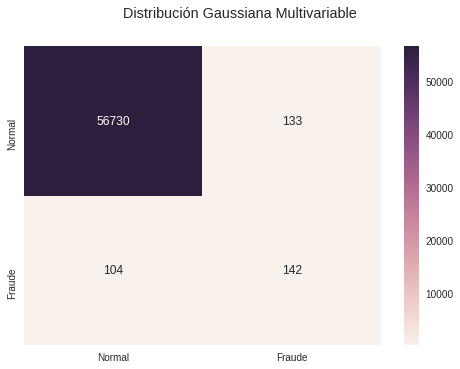

In [11]:
#Confusion Matrix
cfm = confusion_matrix(y_test, final_pred)
yticks = ['Normal','Fraude']
xticks = ['Normal','Fraude']
sns.heatmap(cfm, annot = True,fmt = 'g', xticklabels = xticks, yticklabels= yticks)
sns.plt.suptitle('Distribución Gaussiana Multivariable')
plt.show()


<h1><center>Red Neuronal</center>



In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
pydot.find_graphviz = lambda: True

Using TensorFlow backend.


In [13]:

data = pd.read_csv('./Data/creditcard.csv')

#Normalizacion y features scaling
for f in data.columns.values:
    if f != 'Class':
        mean, std = data[f].mean(), data[f].std()
        data[f] = (data[f] - mean) / std

normal = data[data.Class == 0]
fraud = data[data.Class == 1]
#Separacion de los dataset para entrenamiento y pruebas

#20% de transacciones normales + la mitad de todos los fraudes
X_train = pd.concat([normal.sample(frac = 0.2),fraud.sample(frac = 0.50)], axis = 0)
X_test = pd.concat([normal.sample(frac = 0.2), fraud.sample(frac = 0.50)], axis = 0)

#Random examples
X_random = X_test.sample(frac = 0.10)
y_random = X_random.pop('Class')

y_train, y_test = X_train.pop('Class'), X_test.pop('Class')
#One hot encoding
y_train = LabelEncoder().fit(y_train).transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelEncoder().fit(y_test).transform(y_test)
y_test = to_categorical(y_test)

m, n = X_train.shape
normal_y = normal.pop('Class')
y_fraud = fraud.pop('Class')

In [14]:
#Definicion del modelo
input_size = X_train.shape[1]
output_size = 2
hidden_size = int((2 / 3) * input_size + output_size)

model = Sequential([Dense(hidden_size, activation = 'relu', input_dim = input_size),
                    Dropout(.15),
                    Dense(hidden_size, activation = 'relu'),
                    Dropout(.10),
                    Dense(hidden_size, activation = 'relu'),
                    Dropout(.5),
                    Dense(output_size, activation = 'softmax')
                    ])

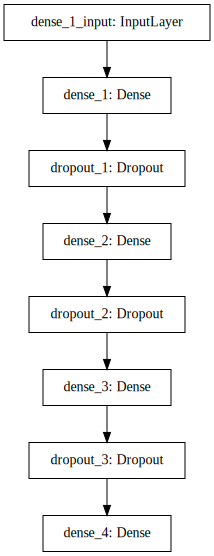

In [15]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
#Entrenamiento
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

model.fit(X_train.as_matrix(), y_train, batch_size = 128,  epochs = 100, verbose = 0);

In [17]:
#Predicciones
pred = model.predict(X_test.as_matrix())
y_test = y_test.argmax(1)
pred = pred.argmax(1)

print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56863
          1       0.91      0.87      0.89       246

avg / total       1.00      1.00      1.00     57109



In [18]:
#Predicciones solo con las transacciones fraudulentas
fraud_pred = model.predict(fraud.as_matrix())

fraud_pred = fraud_pred.argmax(1)

print("Transacciones fraudulentas Detectadas ", accuracy_score(y_fraud, fraud_pred) * 100 , "%")

Transacciones fraudulentas Detectadas  87.8048780488 %


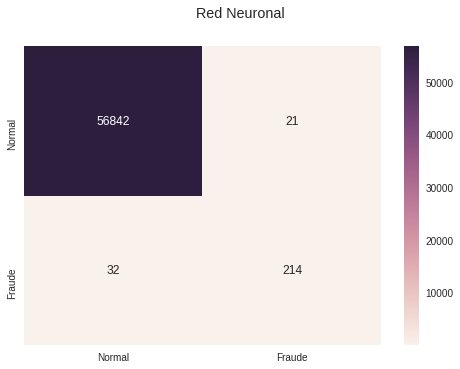

In [19]:
#Matriz de confusion para la red Neuronal
cfm = confusion_matrix(y_test, pred)
xticks = ['Normal','Fraude']
yticks = ['Normal','Fraude']
sns.heatmap(cfm, annot = True,fmt = 'g',xticklabels = xticks, yticklabels= yticks)
sns.plt.suptitle('Red Neuronal')
plt.show()